In [1]:
!pip install evaluate rouge_score git+https://github.com/google-research/bleurt.git bert_score

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-m1vzzr_r
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-m1vzzr_r
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 614.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install openai

In [3]:
!pip install datasets

In [4]:
!pip install evaluate nltk comet-mt unidecode

ERROR: Could not find a version that satisfies the requirement comet-mt (from versions: none)
ERROR: No matching distribution found for comet-mt


In [5]:
from datasets import load_dataset
dataset_xlcost = load_dataset("codeparrot/xlcost-text-to-code", "Python-program-level")['test']
dataset_code_x = load_dataset("google/code_x_glue_ct_code_to_text", 'python')['test']
dataset_code_search_net = load_dataset("code-search-net/code_search_net", 'python')['test']

README.md:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

xlcost-text-to-code.py:   0%|          | 0.00/7.61k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/357k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9263 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/887 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/472 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code-search-net/code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code-search-net/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [6]:
def split_text(example):
    example['text'] = example['text'].split('|')[0].strip()
    return example

dataset_xlcost = dataset_xlcost.map(split_text)

dataset_code_x = dataset_code_x.rename_column('docstring', 'text')

dataset_code_search_net = dataset_code_search_net.rename_column('func_documentation_string', 'text')
dataset_code_search_net = dataset_code_search_net.rename_column('func_code_string', 'code')

Map:   0%|          | 0/887 [00:00<?, ? examples/s]

In [14]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="",
)

In [8]:
system_message = {
      "role": "system",
      "content": "For each code snippet provided as input, output a very brief summary and nothing else. The summary must not include newline characters or full stop symbols. The number of summary outputs must exactly match the number of input code snippets, with each summary separated by the '$' symbol if there are multiple snippets"
    }

In [9]:
import os
import json

def save_to_json(dataset, summaries, references, left, right, filename):
    # Создаем список данных для сохранения
    output_data = []
    for i in range(len(references)):
        if i >= len(summaries):
            break  # Защита от расхождения длин

        sample_idx = left + i
        entry = {
            "code": dataset[sample_idx]['code'],
            "ideal_answer": references[i],
            "generated_answer": summaries[i].strip()
        }
        output_data.append(entry)

    # Создаем директорию, если она не существует
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    # Сохраняем данные в JSON
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

In [10]:
def get_summarization(model, dataset, left, right):
    codes = ""
    refs = []
    for sample in dataset.select(range(left,right)):
        codes +=sample['code'] + "\n$\n"
        refs.append(sample['text'])
    print(len(codes))
    completion = client.chat.completions.create(
        model = model,
        messages=[
          system_message,
          {
            "role": "user",
            "content": codes
          }
        ]
    )
    summary = completion.choices[0].message.content.split('$')

    return summary, refs

In [11]:
def calculate_metrics(preds, refs):
    rouge_result = rouge.compute(predictions=preds, references=refs, rouge_types=["rougeL"])["rougeL"]
    bleu_result = bleu.compute(predictions=preds, references=[[ref] for ref in refs])

    bleurt_scores = bleurt.compute(predictions=preds, references=refs)["scores"]
    avg_bleurt = sum(bleurt_scores) / len(bleurt_scores)

    bert_scores = bertscore.compute(
        predictions=preds,
        references=refs,
        lang="en",
        model_type="microsoft/deberta-large-mnli"
    )
    avg_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"])


    return rouge_result, bleurt_scores, bert_scores, avg_bert_f1

In [12]:
import json
from evaluate import load
import numpy as np

# Загружаем метрики
rouge = load('rouge')
bleu = load('bleu')
bleurt = load('bleurt', checkpoint="bleurt-base-128")
bertscore = load('bertscore')
meteor = load('meteor')

def calculate_metrics_from_file(json_filename):
    with open(json_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    references = [entry["ideal_answer"] for entry in data]
    predictions = [entry["generated_answer"] for entry in data]
    codes = [entry["code"] for entry in data]

    # --- ROUGE ---
    rouge_types = ["rouge1", "rouge2", "rougeL"]
    rouge_results = rouge.compute(predictions=predictions, references=references, rouge_types=rouge_types)

    # --- BLEU ---
    # Вычисляем BLEU для каждого примера индивидуально
    bleu_per_example = []
    for pred, ref in zip(predictions, references):
        if not pred or not ref:  # Обработка пустых строк
            bleu_per_example.append(0.0)
            continue
        result = bleu.compute(predictions=[pred], references=[[ref]])
        bleu_per_example.append(result["bleu"])

    bleu_result = np.mean(bleu_per_example)
    max_bleu = np.max(bleu_per_example)
    min_bleu = np.min(bleu_per_example)

    # --- BLEURT ---
    bleurt_scores = bleurt.compute(predictions=predictions, references=references)["scores"]
    avg_bleurt = np.mean(bleurt_scores)

    # --- BERTScore ---
    bert_scores = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bert_precision = np.mean(bert_scores["precision"])
    avg_bert_recall = np.mean(bert_scores["recall"])
    avg_bert_f1 = np.mean(bert_scores["f1"])

    # --- METEOR ---
    meteor_scores = meteor.compute(predictions=predictions, references=references)["meteor"]

    # Собираем примеры с кодом и метриками
    examples = []
    for i in range(len(data)):
        examples.append({
            "code": codes[i],
            "ideal_answer": references[i],
            "generated_answer": predictions[i],
            "bleu": bleu_per_example[i],
            "bleurt": bleurt_scores[i],
            "bert_precision": bert_scores["precision"][i],
            "bert_recall": bert_scores["recall"][i],
            "bert_f1": bert_scores["f1"][i],
            "meteor": meteor_scores[i] if isinstance(meteor_scores, list) else meteor_scores
        })

    # Находим примеры с максимальными, минимальными и средними значениями для BERTScore
    def find_extremes(metric_key):
        values = [example[metric_key] for example in examples]
        max_value = max(values)
        min_value = min(values)
        mean_value = np.mean(values)

        # Находим ближайший пример к среднему значению
        closest_to_mean_index = np.argmin([abs(v - mean_value) for v in values])

        return {
            "max": [examples[i] for i, v in enumerate(values) if v == max_value],
            "min": [examples[i] for i, v in enumerate(values) if v == min_value],
            "mean": examples[closest_to_mean_index]
        }

    bert_precision_extremes = find_extremes("bert_precision")
    bert_recall_extremes = find_extremes("bert_recall")
    bert_f1_extremes = find_extremes("bert_f1")

    # Возвращаем результаты с детализацией
    return {
        "overall_metrics": {
            "rouge1": rouge_results["rouge1"],
            "rouge2": rouge_results["rouge2"],
            "rougeL": rouge_results["rougeL"],
            "bleu": bleu_result,
            "max_bleu": max_bleu,
            "min_bleu": min_bleu,
            "avg_bleurt": avg_bleurt,
            "avg_bert_precision": avg_bert_precision,
            "avg_bert_recall": avg_bert_recall,
            "avg_bert_f1": avg_bert_f1,
            "meteor": meteor_scores
        },
        "examples": examples,
        "bert_extremes": {
            "precision": bert_precision_extremes,
            "recall": bert_recall_extremes,
            "f1": bert_f1_extremes
        }
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [13]:
import matplotlib.pyplot as plt

def plot_metrics_from_file(json_filename):
    results = calculate_metrics_from_file(json_filename)

    # Вывод BLEU статистики
    print(f"Max BLEU: {results['overall_metrics']['max_bleu']:.2f}")
    print(f"Min BLEU: {results['overall_metrics']['min_bleu']:.2f}")
    print(f"Avg BLEU: {results['overall_metrics']['bleu']:.2f}")
    print("\nExample with highest BLEU:")
    best_example = max(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {best_example['code']}")
    print(f"Ideal: {best_example['ideal_answer']}")
    print(f"Generated: {best_example['generated_answer']}")
    print(f"BLEU: {best_example['bleu']:.2f}")
    print("\n\nExample with smallest BLEU:")
    worst_example = min(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {worst_example['code']}")
    print(f"Ideal: {worst_example['ideal_answer']}")
    print(f"Generated: {worst_example['generated_answer']}")
    print(f"BLEU: {worst_example['bleu']:.2f}")

    # Функция для поиска примеров с экстремальными значениями метрики
    def find_extreme_examples(metric_key):
        examples = results["examples"]
        max_example = max(examples, key=lambda x: x[metric_key])
        min_example = min(examples, key=lambda x: x[metric_key])
        avg_value = sum(x[metric_key] for x in examples) / len(examples)
        closest_to_avg = min(examples, key=lambda x: abs(x[metric_key] - avg_value))
        return max_example, min_example, closest_to_avg, avg_value

    # BERT Recall статистика
    max_recall, min_recall, avg_recall, avg_recall_value = find_extreme_examples("bert_recall")
    print(f"\nMax Avg BERT Recall: {max_recall['bert_recall']:.2f}")
    print(f"Min Avg BERT Recall: {min_recall['bert_recall']:.2f}")
    print(f"Avg Avg BERT Recall: {avg_recall_value:.2f}")
    print("\nExample with highest Avg BERT Recall:")
    print(f"Code: {max_recall['code']}")
    print(f"Ideal: {max_recall['ideal_answer']}")
    print(f"Generated: {max_recall['generated_answer']}")
    print(f"BERT Recall: {max_recall['bert_recall']:.2f}")
    print("\nExample with smallest Avg BERT Recall:")
    print(f"Code: {min_recall['code']}")
    print(f"Ideal: {min_recall['ideal_answer']}")
    print(f"Generated: {min_recall['generated_answer']}")
    print(f"BERT Recall: {min_recall['bert_recall']:.2f}")
    print("\nExample closest to Avg BERT Recall:")
    print(f"Code: {avg_recall['code']}")
    print(f"Ideal: {avg_recall['ideal_answer']}")
    print(f"Generated: {avg_recall['generated_answer']}")
    print(f"BERT Recall: {avg_recall['bert_recall']:.2f}")

    # BERT F1 статистика
    max_f1, min_f1, avg_f1, avg_f1_value = find_extreme_examples("bert_f1")
    print(f"\nMax Avg BERT F1: {max_f1['bert_f1']:.2f}")
    print(f"Min Avg BERT F1: {min_f1['bert_f1']:.2f}")
    print(f"Avg Avg BERT F1: {avg_f1_value:.2f}")
    print("\nExample with highest Avg BERT F1:")
    print(f"Code: {max_f1['code']}")
    print(f"Ideal: {max_f1['ideal_answer']}")
    print(f"Generated: {max_f1['generated_answer']}")
    print(f"BERT F1: {max_f1['bert_f1']:.2f}")
    print("\nExample with smallest Avg BERT F1:")
    print(f"Code: {min_f1['code']}")
    print(f"Ideal: {min_f1['ideal_answer']}")
    print(f"Generated: {min_f1['generated_answer']}")
    print(f"BERT F1: {min_f1['bert_f1']:.2f}")
    print("\nExample closest to Avg BERT F1:")
    print(f"Code: {avg_f1['code']}")
    print(f"Ideal: {avg_f1['ideal_answer']}")
    print(f"Generated: {avg_f1['generated_answer']}")
    print(f"BERT F1: {avg_f1['bert_f1']:.2f}")

    # Извлекаем все метрики из результатов
    metrics = [
        "ROUGE-1",
        "ROUGE-2",
        "ROUGE-L",
        "BLEU",
        "Avg BLEURT",
        "Avg BERTScore F1",
        "Avg BERTScore Precision",
        "Avg BERTScore Recall",
        "METEOR"
    ]
    scores = [
        results["overall_metrics"]["rouge1"],
        results["overall_metrics"]["rouge2"],
        results["overall_metrics"]["rougeL"],
        results["overall_metrics"]["bleu"],
        results["overall_metrics"]["avg_bleurt"],
        results["overall_metrics"]["avg_bert_f1"],
        results["overall_metrics"]["avg_bert_precision"],
        results["overall_metrics"]["avg_bert_recall"],
        results["overall_metrics"]["meteor"]
    ]

    # Разделяем метрики по типам для цветового кодирования
    rouge_metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
    bert_metrics = ["Avg BERTScore F1", "Avg BERTScore Precision", "Avg BERTScore Recall"]
    other_metrics = ["BLEU", "Avg BLEURT", "METEOR"]

    # Создаем цветовую схему
    colors = []
    for metric in metrics:
        if metric in rouge_metrics:
            colors.append('lightcoral')
        elif metric in bert_metrics:
            colors.append('lightskyblue')
        else:
            colors.append('skyblue')

    # Создаем график
    plt.figure(figsize=(16, 7))
    bars = plt.bar(metrics, scores, color=colors, edgecolor='black')

    # Поворот меток оси X
    plt.xticks(rotation=45, ha='right')

    # Настройка графика
    plt.title(f"All Metrics for {json_filename}", fontsize=16)
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)

    # Автоматические пределы по оси Y
    ymin = min(scores) - 0.1
    ymax = max(scores) + 0.1
    plt.ylim(ymin, ymax)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Добавляем значения над столбцами
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{score:.2f}",
            ha='center',
            fontsize=11
        )

    # Легенда
    rouge_patch = plt.Line2D([0], [0], color='lightcoral', lw=4, label='ROUGE Metrics')
    bert_patch = plt.Line2D([0], [0], color='lightskyblue', lw=4, label='BERTScore Metrics')
    other_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Other Metrics')

    plt.legend(
        handles=[rouge_patch, bert_patch, other_patch],
        loc='upper right',
        fontsize=11,
        frameon=True,
        shadow=True
    )

    plt.tight_layout()
    plt.show()

45228
Max BLEU: 0.00
Min BLEU: 0.00
Avg BLEU: 0.00

Example with highest BLEU:
Code: def minSum ( A , N ) : NEW_LINE INDENT mp = { } NEW_LINE sum = 0 NEW_LINE for i in range ( N ) : NEW_LINE INDENT sum += A [ i ] NEW_LINE if A [ i ] in mp : NEW_LINE INDENT mp [ A [ i ] ] += 1 NEW_LINE DEDENT else : NEW_LINE INDENT mp [ A [ i ] ] = 1 NEW_LINE DEDENT DEDENT minSum = float ( ' inf ' ) NEW_LINE for it in mp : NEW_LINE INDENT minSum = min ( minSum , sum - ( it * mp [ it ] ) ) NEW_LINE DEDENT return minSum NEW_LINE DEDENT arr = [ 4 , 5 , 6 , 6 ] NEW_LINE N = len ( arr ) NEW_LINE print ( minSum ( arr , N ) ) NEW_LINE
Ideal: Minimum sum possible by removing all occurrences of any array element
Generated: calculates minimum sum by removing one distinct element from array
BLEU: 0.00


Example with smallest BLEU:
Code: def minSum ( A , N ) : NEW_LINE INDENT mp = { } NEW_LINE sum = 0 NEW_LINE for i in range ( N ) : NEW_LINE INDENT sum += A [ i ] NEW_LINE if A [ i ] in mp : NEW_LINE INDENT mp [ A [

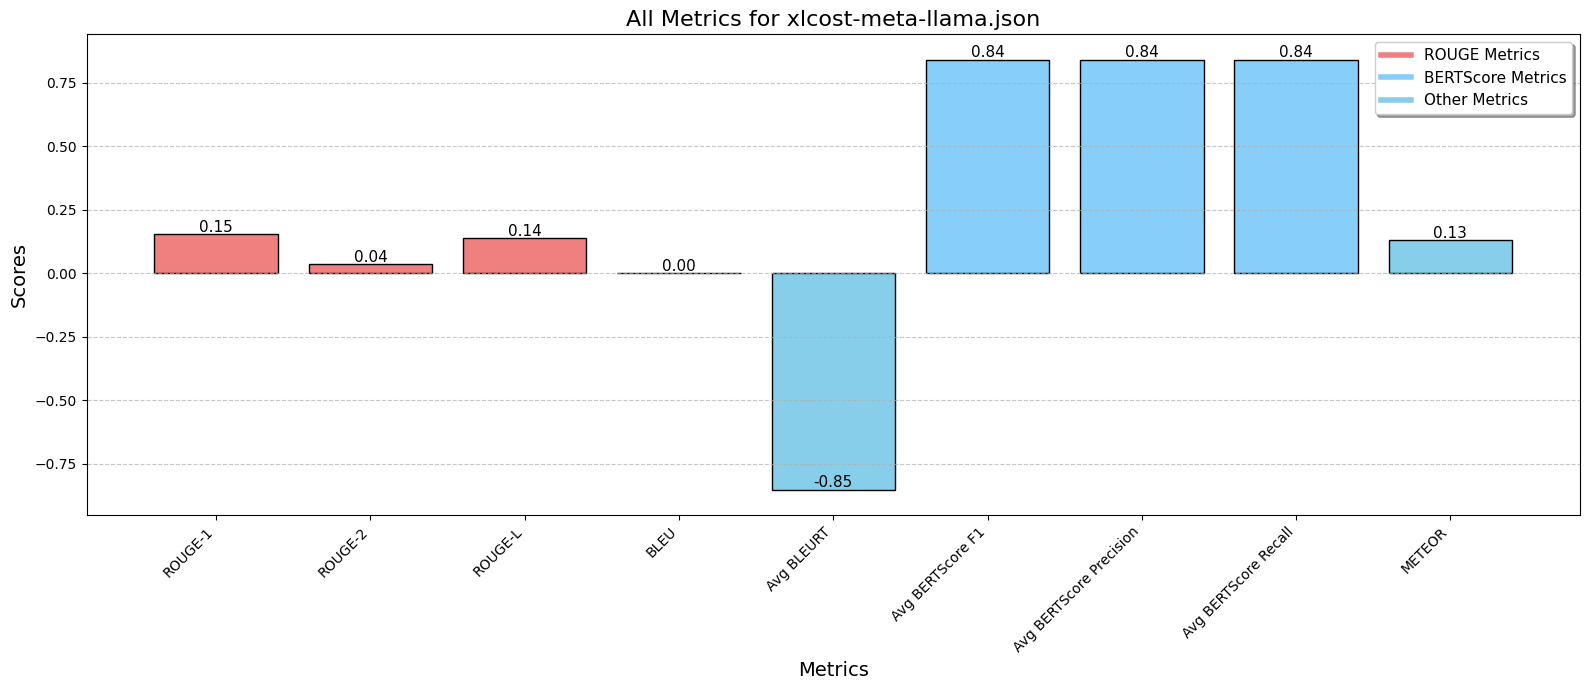

In [23]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_xlcost, 0, 70)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 70, "xlcost-meta-llama.json")
plot_metrics_from_file("xlcost-meta-llama.json")



49844
Max BLEU: 0.88
Min BLEU: 0.00
Avg BLEU: 0.17

Example with highest BLEU:
Code: from math import * NEW_LINE def isPerfectSquare ( x ) : NEW_LINE INDENT sr = sqrt ( x ) NEW_LINE return ( ( sr - floor ( sr ) ) == 0 ) NEW_LINE DEDENT def checkSunnyNumber ( N ) : NEW_LINE INDENT if ( isPerfectSquare ( N + 1 ) ) : NEW_LINE INDENT print ( " Yes " ) NEW_LINE DEDENT else : NEW_LINE INDENT print ( " No " ) NEW_LINE DEDENT DEDENT if __name__ == ' _ _ main _ _ ' : NEW_LINE INDENT N = 8 NEW_LINE checkSunnyNumber ( N ) NEW_LINE DEDENT
Ideal: Splicing URLs according to video ID to get video details
Generated: splicing URLs according to video ID to get video details
BLEU: 0.88


Example with smallest BLEU:
Code: def minSum ( A , N ) : NEW_LINE INDENT mp = { } NEW_LINE sum = 0 NEW_LINE for i in range ( N ) : NEW_LINE INDENT sum += A [ i ] NEW_LINE if A [ i ] in mp : NEW_LINE INDENT mp [ A [ i ] ] += 1 NEW_LINE DEDENT else : NEW_LINE INDENT mp [ A [ i ] ] = 1 NEW_LINE DEDENT DEDENT minSum = float 

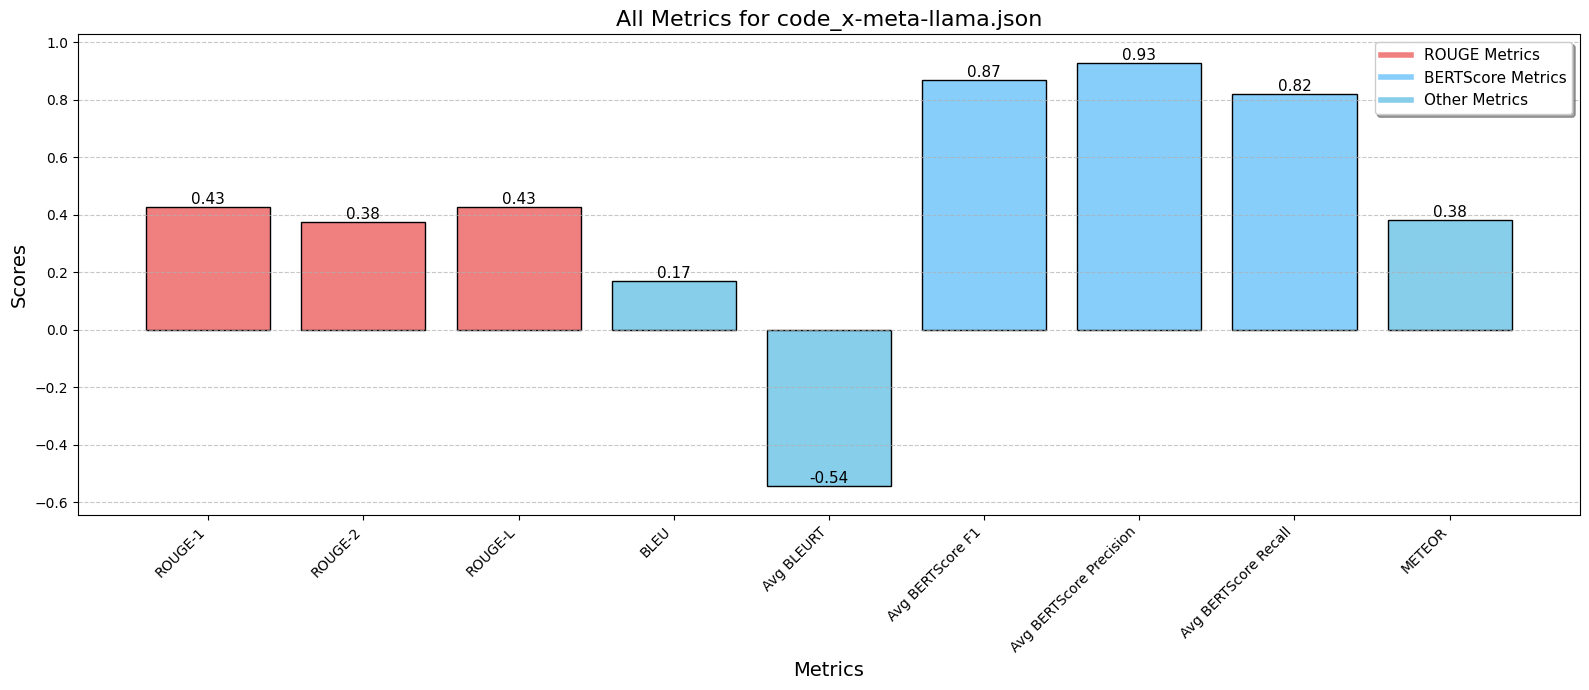

In [24]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_code_x , 0, 50)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 50, "code_x-meta-llama.json")
plot_metrics_from_file("code_x-meta-llama.json")


39963
Max BLEU: 0.45
Min BLEU: 0.00
Avg BLEU: 0.05

Example with highest BLEU:
Code: MAX = 1000000 NEW_LINE MOD = 10 ** 9 + 7 NEW_LINE result = [ 0 for i in range ( MAX + 1 ) ] NEW_LINE fact = [ 0 for i in range ( MAX + 1 ) ] NEW_LINE def preCompute ( ) : NEW_LINE INDENT fact [ 0 ] = 1 NEW_LINE result [ 0 ] = 1 NEW_LINE for i in range ( 1 , MAX + 1 ) : NEW_LINE INDENT fact [ i ] = ( ( fact [ i - 1 ] % MOD ) * i ) % MOD NEW_LINE result [ i ] = ( ( result [ i - 1 ] % MOD ) * ( fact [ i ] % MOD ) ) % MOD NEW_LINE DEDENT DEDENT def performQueries ( q , n ) : NEW_LINE INDENT preCompute ( ) NEW_LINE for i in range ( n ) : NEW_LINE INDENT print ( result [ q [ i ] ] ) NEW_LINE DEDENT DEDENT q = [ 4 , 5 ] NEW_LINE n = len ( q ) NEW_LINE performQueries ( q , n ) NEW_LINE
Ideal: Print a log message to standard error.
Generated: print_log prints log message to standard error
BLEU: 0.45


Example with smallest BLEU:
Code: def findSize ( N ) : NEW_LINE INDENT if ( N == 0 ) : NEW_LINE INDENT return 1

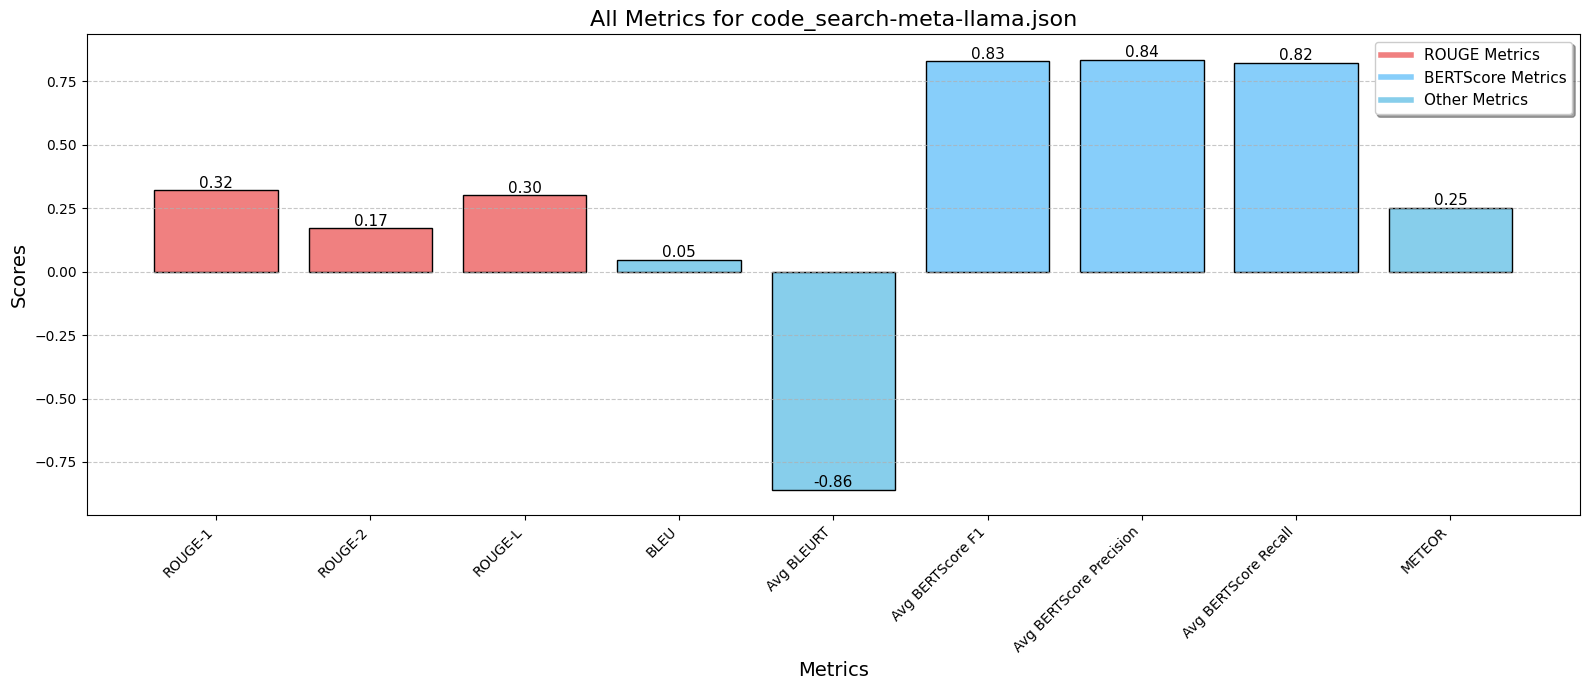

In [26]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_code_search_net , 0, 50)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 50, "code_search-meta-llama.json")
plot_metrics_from_file("code_search-meta-llama.json")

